In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

# Функция заполнения пропусков 
def data_education_fillna():
    df = pd.read_csv('train.csv')

    # Обработаем категориальные признаки
    from sklearn.preprocessing import LabelEncoder, StandardScaler
    encoder = LabelEncoder()
    scaler = StandardScaler()

    df.education = df.education.fillna('NAN')
    #df.education = encoder.fit_transform(df.education)

    df_train = df[df.education != 'NAN']
    df_test = df[df.education == 'NAN']

    df_train.education = encoder.fit_transform(df_train.education)

    df_train = pd.get_dummies(df_train)
    df_test = pd.get_dummies(df_test.drop('education', axis=1))

    # Разбиваем данные для обучения модели
    from sklearn.model_selection import train_test_split
    from sklearn.utils import resample

    # Обучаем модель
    from sklearn.ensemble import RandomForestClassifier

    y = df_train.education
    X = df_train.drop('education', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Обучаем модель
    model = RandomForestClassifier(max_depth=20, n_estimators=500)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Заполним пропуски education при помощи RFC
    missing_education = model.predict(df_test)
    df_test['education'] = encoder.inverse_transform(missing_education)


    return df_test


# Функция обработки данных
def prepare_data(fill_na='rfc', use_fe=False, binarize_categorical=True, read_from_file=False):
    '''
    fill_na parameter: 
        - rfc: fill with RandomForestClassifier
        - mean: fill with mean value
        - mode: fill with mode value
        - drop: drop NAN values
    '''
    CSV_FILENAME = 'prepared_data.csv'

    if read_from_file:
        df = pd.read_csv(CSV_FILENAME)
        X = df.drop('default', axis=1)
        y = df.default

        return X, y, df 

    # Загружаем датасет
    df = pd.read_csv('train.csv')

    # Распределим признаки по типам
    num_features = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'client_id']
    binary_features = ['sex', 'car', 'car_type', 'foreign_passport']
    cat_features = ['education', 'home_address', 'work_address']
    other_features = ['good_work']

    # Заполним пропуски
    if fill_na in ['rfc', 'mean', 'mode', 'drop']:
        if fill_na == 'rfc':
            df_filled = data_education_fillna()
            df.education = df.education.fillna(df_filled.education)
        elif fill_na == 'mean':
            df.education = df.education.fillna(df.education.value_counts()
                            [df.education.value_counts() == int(df.education.value_counts().median())].index[0])
        elif fill_na == 'mode':
            df.education = df.education.fillna(df.education.mode()[0])
        elif fill_na == 'drop':
            df = df.dropna(axis=0)
    else:
        raise Exception('fill_na parameter has to be: rfc, mean, mode or drop]')

    # Логарифмируем числовые переменные
    df[num_features] = df[num_features].apply(lambda x: np.log(x+1))

    # Закодируем бинарные признаки
    from sklearn.preprocessing import LabelEncoder

    labelEncoder = LabelEncoder()

    for feature in binary_features:
        df[feature] = labelEncoder.fit_transform(df[feature])

    # Закодируем образование
    df.education = labelEncoder.fit_transform(df.education)

    # Feature Engineering
    if use_fe:
        added_features =[]
    else:
        added_features = []

    # Выполним OneHotEncoding категориальных признаков
    from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler

    if binarize_categorical:
        ohe = OneHotEncoder(sparse = False)
        X_cat = ohe.fit_transform(df[cat_features].values)
        # Получим новые названия категориальных признаков после OHE
        cat_f = list(ohe.get_feature_names(cat_features))
    else:
        X_cat = df[cat_features].values
        cat_f = cat_features

    # Выполним нормирование числовых признаков
    X_num = RobustScaler().fit_transform(df[num_features].values)

    # Объединим все признаки
    X = np.hstack([X_num, df[binary_features].values, X_cat, df[other_features].values, df[added_features].values])
    y = df['default'].values

    # Соберем датафрэйм
    prepared_df = pd.DataFrame(np.hstack([X, y.reshape(-1, 1)]), columns=num_features+binary_features+cat_f
                                                                +other_features+added_features+['default'])

    # Сохраним данные в файл
    prepared_df.to_csv(CSV_FILENAME, index=False)

    return X, y, prepared_df

In [2]:
df = pd.read_csv('train.csv')

<table style="width: 80%; font-size: 16px; padding: 0.3em; border-collapse: collapse; margin: 0px auto; border: 1px solid #b3b3b3;">
<tbody>
<tr>
<td style="width: 34.3096%; border: 1px solid #b3b3b3; padding: 0.3em;">client_id</td>
<td style="width: 65.5509%; border: 1px solid #b3b3b3; padding: 0.3em;">идентификатор клиента</td>
</tr>
<tr>
<td style="width: 34.3096%; border: 1px solid #b3b3b3; padding: 0.3em;">education</td>
<td style="width: 65.5509%; border: 1px solid #b3b3b3; padding: 0.3em;">уровень образования</td>
</tr>
<tr>
<td style="width: 34.3096%; border: 1px solid #b3b3b3; padding: 0.3em;">sex</td>
<td style="width: 65.5509%; border: 1px solid #b3b3b3; padding: 0.3em;">пол заёмщика</td>
</tr>
<tr>
<td style="width: 34.3096%; border: 1px solid #b3b3b3; padding: 0.3em;">age</td>
<td style="width: 65.5509%; border: 1px solid #b3b3b3; padding: 0.3em;">возраст заёмщика</td>
</tr>
<tr>
<td style="width: 34.3096%; border: 1px solid #b3b3b3; padding: 0.3em;">car</td>
<td style="width: 65.5509%; border: 1px solid #b3b3b3; padding: 0.3em;">флаг наличия автомобиля</td>
</tr>
<tr>
<td style="width: 34.3096%; border: 1px solid #b3b3b3; padding: 0.3em;">car_type</td>
<td style="width: 65.5509%; border: 1px solid #b3b3b3; padding: 0.3em;">флаг автомобиля-иномарки</td>
</tr>
<tr>
<td style="width: 34.3096%; border: 1px solid #b3b3b3; padding: 0.3em;">decline_app_cnt</td>
<td style="width: 65.5509%; border: 1px solid #b3b3b3; padding: 0.3em;">количество отказанных прошлых заявок</td>
</tr>
<tr>
<td style="width: 34.3096%; border: 1px solid #b3b3b3; padding: 0.3em;">good_work</td>
<td style="width: 65.5509%; border: 1px solid #b3b3b3; padding: 0.3em;">флаг наличия «хорошей» работы</td>
</tr>
<tr>
<td style="width: 34.3096%; border: 1px solid #b3b3b3; padding: 0.3em;">bki_request_cnt</td>
<td style="width: 65.5509%; border: 1px solid #b3b3b3; padding: 0.3em;">количество запросов в БКИ</td>
</tr>
<tr>
<td style="width: 34.3096%; border: 1px solid #b3b3b3; padding: 0.3em;">home_address</td>
<td style="width: 65.5509%; border: 1px solid #b3b3b3; padding: 0.3em;">категоризатор домашнего адреса</td>
</tr>
<tr>
<td style="width: 34.3096%; border: 1px solid #b3b3b3; padding: 0.3em;">work_address</td>
<td style="width: 65.5509%; border: 1px solid #b3b3b3; padding: 0.3em;">категоризатор рабочего адреса</td>
</tr>
<tr>
<td style="width: 34.3096%; border: 1px solid #b3b3b3; padding: 0.3em;">income</td>
<td style="width: 65.5509%; border: 1px solid #b3b3b3; padding: 0.3em;">доход заёмщика</td>
</tr>
<tr>
<td style="width: 34.3096%; border: 1px solid #b3b3b3; padding: 0.3em;">foreign_passport</td>
<td style="width: 65.5509%; border: 1px solid #b3b3b3; padding: 0.3em;">наличие загранпаспорта</td>
</tr>
<tr>
<td style="width: 34.3096%; border: 1px solid #b3b3b3; padding: 0.3em;">default</td>
<td style="width: 65.5509%; border: 1px solid #b3b3b3; padding: 0.3em;">наличие дефолта</td>
</tr>
</tbody>
</table>

In [ ]:
df.education.value_counts()[df.education.value_counts() == int(df.education.value_counts().median())].index[0]

In [ ]:
# Распределим признаки по типам
num_features = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
binary_features = ['sex', 'car', 'car_type', 'foreign_passport']
cat_features = ['education', 'home_address', 'work_address']


In [ ]:
sns.countplot(x='education', data=df, hue='education')

df.education.value_counts()

In [ ]:
# Посмотрим баланс классов
sns.countplot(x='default', data=df, hue='sex')

In [ ]:
report = ProfileReport(df)
#report.to_file('report.html')

In [ ]:
# Посмотрим на пропуски
import missingno as msno
msno.matrix(df)

In [ ]:
# Заполним пропуски
df_filled = data_education_fillna()

# Объединим в рабочий датасет и заполним пропуски с предсказанными классами Education
df.education = df.education.fillna(df_filled.education)

# Проверим результат модели при заполнении модой
# df.education = df.education.fillna(df.education.mode()[0])

# Посмотрим распределение предсказанных классов
sns.countplot(x='education', data=df, hue='education')



,decline_app_cnt
count,73799.000000
nan,0.000000
min,0.000000
max,33.000000
median,0.000000
mean,0.275749


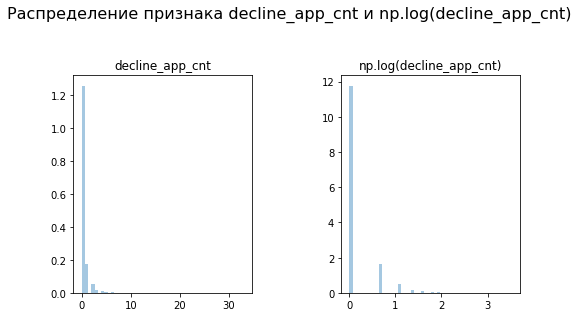

In [4]:
# Посмотрим на графики распределения переменных
from dshelpers.EDA import plot_dist_log

plot_dist_log(df, 'decline_app_cnt', figsize=(8,4))

In [15]:
# Логарифмируем числовые переменные
column = 'age'


,age
count,73799.000000
nan,0.000000
min,21.000000
max,72.000000
median,37.000000
mean,39.280641


In [ ]:
for i, feature in enumerate(num_features):
    sns.distplot(df[feature], kde = False, rug=False)
    plt.title(feature)
    plt.show()

In [ ]:
# Построим боксплоты числовых признаков
for feature in num_features:
    sns.boxplot(x='default', y=feature, data=df)
    plt.show()

In [ ]:
# Посмотрим на корреляцию числовых переменных
sns.heatmap(df[num_features].corr().abs(), vmin=0, vmax=1, annot=True)

In [ ]:
# Посмотрим на наиболее важные признаки
from dshelpers.EDA import plot_fclassif, plot_mutual_info_classif
plot_fclassif(df, num_features, 'default')

In [ ]:
# Закодируем бинарные признаки
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()

for feature in binary_features:
    df[feature] = labelEncoder.fit_transform(df[feature])

df.education = labelEncoder.fit_transform(df.education)

plot_mutual_info_classif(df, binary_features+cat_features, 'default')

# Подготавливаем модель

## BaseLine LogisticRegression AUC = 0.680

In [ ]:
X, y, df = prepare_data(use_fe=True, read_from_file=True)

# Разобьем датасет и обучим модеь
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

model = LogisticRegression(penalty='l2')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(model, X_train, y_train, values_format='d')

probs = model.predict_proba(X_test)
probs = probs[:,1]

from dshelpers.METRICS import roc_auc_plot
roc_auc_plot(y_test, probs)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split

X, y, df = prepare_data(read_from_file=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

model = LogisticRegression(random_state=42)
iter_ = 50
epsilon_stop = 1e-3
C = np.random.randn(0, 10, 0.1)
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

##печатаем метрики
preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

In [ ]:
from dshelpers.METRICS import roc_auc_plot
from sklearn.metrics import plot_confusion_matrix
roc_auc_plot(y_test, model.predict_proba(X_test)[:, 1])
plot_confusion_matrix(model, X_train, y_train, values_format='d')

In [ ]:
# Попробуем обучить модель на Under-sample
from sklearn.utils import resample
X, y, df = prepare_data(fill_na='mode')

zero_class = df[df.default == 0]
ones_class = df[df.default == 1]

balanced_df = resample(zero_class, n_samples=len(ones_class), replace=True, random_state=42).append(ones_class)
balanced_X = balanced_df.drop('default', axis=1)
balanced_y = balanced_df.default

# Построим модель на сбалансированной выборке
X_train, X_test, y_train, y_test = train_test_split(balanced_X, balanced_y, test_size=0.20, random_state=42)

model = LogisticRegression(penalty='l2', C=1)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]

y_pred = model.predict(X_test)

roc_auc_plot(y_test, probs)
plot_confusion_matrix(model, X_train, y_train)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
X, y, df = prepare_data(fill_na='mode')

# Построим модель на сбалансированной выборке
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

model = GradientBoostingClassifier()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]

y_pred = model.predict(X_test)

roc_auc_plot(y_test, probs)

In [ ]:
df.head()

In [ ]:
from catboost import CatBoostClassifier

X, y, df = prepare_data()

# Построим модель на сбалансированной выборке
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

model = CatBoostClassifier(verbose=0)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]

y_pred = model.predict(X_test)

roc_auc_plot(y_test, probs)

# Feature Engineering

In [ ]:
import featuretools as ft

X, y, df = prepare_data(binarize_categorical=True)

# Make an entityset and add the entity
es = ft.EntitySet(id = 'scoring')
es.entity_from_dataframe(entity_id = 'data', dataframe = df.drop('default', axis=1), 
                         make_index = True, index = 'index')

#es = es.normalize_entity(base_entity_id='data', new_entity_id='age', index='age')

# Run deep feature synthesis with transformation primitives
feature_matrix, feature_defs = ft.dfs(entityset = es, target_entity = 'data', max_depth=2)


# Разобьем датасет и обучим модеь
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

X = feature_matrix
y = df.default

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

model = LogisticRegression(penalty='l2')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(model, X_train, y_train, values_format='d')

probs = model.predict_proba(X_test)
probs = probs[:,1]

from dshelpers.METRICS import roc_auc_plot
roc_auc_plot(y_test, probs)

In [ ]:
feature_matrix.head()

In [ ]:
feature_matrix.head()

In [5]:
np.random.rand(0, 1, 0.1)

TypeError: 'float' object cannot be interpreted as an integer

In [7]:
X, y, df = prepare_data(read_from_file=True)

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipe = make_pipeline(StandardScaler(), LogisticRegression())

pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [15]:
y_pred = pipe.predict(X_test)

In [16]:
model = LogisticRegression(C=7, 
                           penalty='l2', 
                           multi_class = 'ovr', 
                           class_weight='balanced', 
                           solver='liblinear', 
                           random_state=RANDOM_SEED,
                           max_iter=1000)

model.fit(X_train, y_train)



array([0., 0., 0., ..., 0., 0., 0.])